In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
import sys
from functools import partial 
from scipy import stats, optimize
import scipy
from tqdm import tqdm
from appstatpy.ExternalFunctions import *
from appstatpy.LatexFunctions import *
from sympy import *

### Patients are either healthy or infected with Anoroc disease and their temperature, blood
### pressure and age is found in www.nbi.dk/∼petersen/data_AnorocDisease.txt. For patients
### 1-900 (control) the outcome in known, while it is unknown for patients 901-1000 (unknown)
- Using the control sample, plot the three distributions for healthy and sick, respectively.
Which of the three single measures gives the highest separation between healthy and sick?

Besides loading the data, and seperating it into training and testing dataset, we likewise try to plot each different variable in the test as a histogram to spot if there is any obvious shift between the two cases. To quickly filter the test data we used a mask generated by the last column in the data set. 

Looking at the plots, it is clear that "Temperature" is the variable where the two distributions of each types are most seperated. To show this in a more general sense, we likewise create a ROC curve for each of the varaibles, where we slide a threshold through the data and measure how good a classifier this variable is. Looking at the plot below we again see that 'Temperature' is the one where the best classification is obtained.


In [2]:
data = np.genfromtxt('data_AnrocDisease.txt', delimiter = ',', skip_header = 1)
control = data[:900,:]
unknown = data[900:,:]
header = ['PatientID', 'Temp', 'BloodP', 'Age',  'Status']

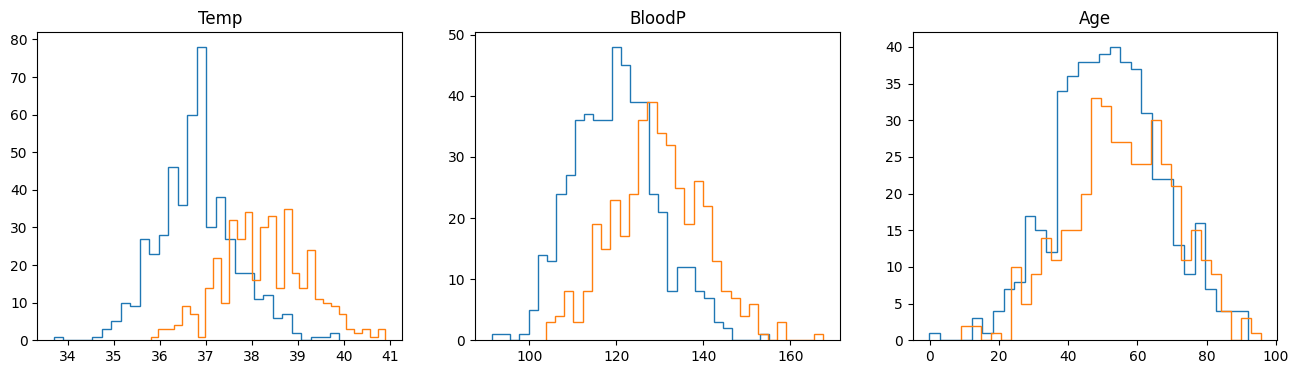

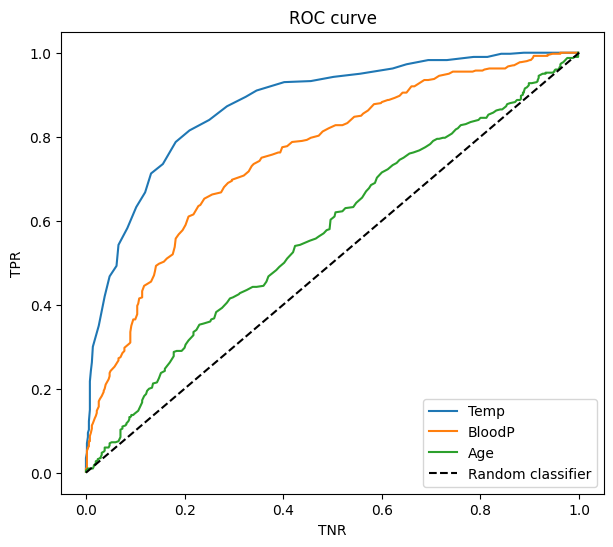

In [3]:
fig, ax = plt.subplots(1,3, figsize = (16, 4))

control_pos = control[np.where(control[:,-1] == 1)] #masking the data by using the last row with status
control_neg = control[np.where(control[:,-1] != 1)]

def TPR_n_TNR(data_pos, data_neg, axis, array):
    TPR = np.zeros_like(array)
    P = data_pos.shape[0]
    TNR = np.zeros_like(array)
    N = data_neg.shape[0]
    for i, val in enumerate(array):
        if len(data_pos.shape) == 1:
            TP = np.sum(np.where(data_pos < val, 0, 1))
            FP = np.sum(np.where(data_neg > val, 1, 0))
        else:
            TP = np.sum(np.where(data_pos[:,axis] < val, 0, 1))
            FP = np.sum(np.where(data_neg[:,axis] > val, 1, 0))
            
     
        TPR[i] = TP/P
        TNR[i] = FP/N
    return TPR, TNR

fig_roc, ax_roc = plt.subplots(1,1, figsize = (7,6))

for i in range(1,4,1):
    ax[i-1].hist(control_neg[:,i], bins = 30, histtype = 'step')
    ax[i-1].hist(control_pos[:,i], bins = 30, histtype = 'step')
    ax[i-1].set_title(header[i])
    array = np.linspace(np.min(control[:,i]), np.max(control[:,i]), 300)
    TPR, TNR = TPR_n_TNR(control_pos, control_neg, i, array)
    ax_roc.plot(TNR, TPR, label = header[i])

ax_roc.plot([0,1], [0,1], color = 'black', ls = '--', label = 'Random classifier')
ax_roc.set(xlabel = 'TNR', ylabel = 'TPR', title = 'ROC curve')
ax_roc.legend()

fig.savefig('images/types_hist')
fig.savefig('images/Roc_inital')
    





- Test if the age distribution is statistically the same between healthy and sick

Here we will devise two methods to check if these are statistically coherrent. Both bulids on the assumption that the two distributions are gaussian. Looking at the plot from previous, we can observe that this is a good estimation, but in more diffuse cases we might need to investigate this beforehand by conducting a fit.

First we devise a Z test on both distributions
$$z = \frac{\mu_i - \mu_j}{\sqrt{\sigma(\mu_j)^2 + \sigma(\mu_i)^2}}$$

Here $\mu$ is the mean of the distribution and $\sigma(\mu)$ is the error on the mean

In [4]:
mean_neg = np.mean(control_neg[:,-2])
error_neg = np.std(control_neg[:,-2], ddof = 1)#/control_neg.shape[0]
print(error_neg)

mean_pos = np.mean(control_pos[:,-2])
error_pos = np.std(control_pos[:,-2],ddof = 1)#/control_pos.shape[0]
print(mean_neg)



z = (mean_pos - mean_neg)/(np.sqrt(error_pos**2 + error_neg**2))


p_val = 2*stats.norm.sf(z, 0, 1)

p_val = scipy.stats.kstest(control_neg[:,-2], control_pos[:,-2])

print(p_val)



15.117910665358872
52.0366
KstestResult(statistic=0.126, pvalue=0.0015705311225052599, statistic_location=62.7, statistic_sign=1)


- Given any combination of all three variables, separate the two groups as well as possible and estimate
the number of infected patients in the unknown group.

The greatest possible separation of the three variables is, under the constraint of being limited to weighted
linear combinations, given by linear discriminant analysis (LDA). Performing LDA on the three distributions
yields the ideal weights for (temperature, blood pressure, age) given below.⃗
$$\mathcal{w} = (0.938, 0.0281, 0.0148) $$
Which is heavily dominated by temperature, followed by blood pressure, in agreement with what is seen
in the figure. The ROC curve for the ideal linear combination is shown in the figure below in comparison to the
unprocessed variables. This shows an improvement relative to the previous best performer, temperature,
though being very slight, which is unsurprising considering the linear combination is heavily dominated by
temperature.

[0.8381358  0.02481075 0.01334501]
81 9.0 19 4.358898943540674


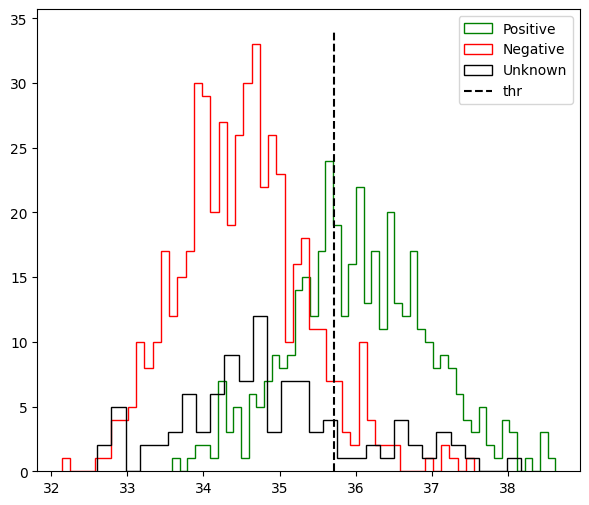

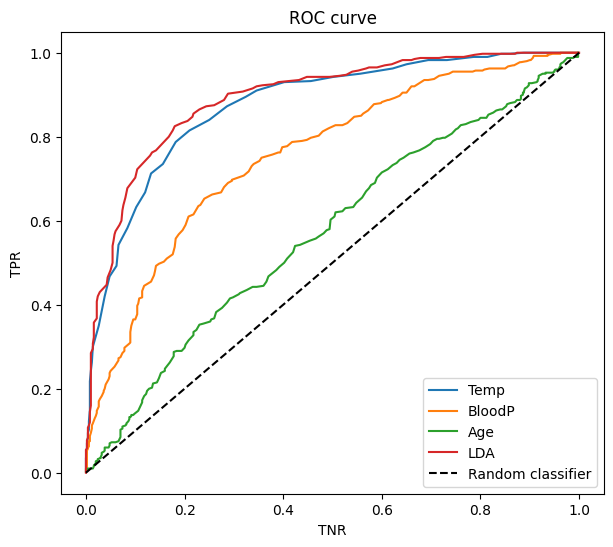

In [5]:
def FDA(spec_A, spec_B, labels=None):

    mu_A = np.mean(spec_A, 0)
    mu_B = np.mean(spec_B, 0)

    cov_A = np.cov(spec_A.T)
    cov_B = np.cov(spec_B.T)
    cov_sum = cov_A + cov_B

    # inverts cov_sum
    cov_sum_inv = np.linalg.inv(cov_sum)

    wf = np.dot(cov_sum_inv.T, (mu_A - mu_B))

    fisher_data_A = np.dot(wf, spec_A.T)
    fisher_data_B = np.dot(wf, spec_B.T)

    return fisher_data_A, fisher_data_B, wf

Array_A, Array_B, w = FDA(control_pos[:, 1:-1], control_neg[:, 1:-1])
print(w)

unknown_lda = np.dot(w, unknown[:, 1:-1].T)

fig, ax = plt.subplots(1,1, figsize = (7,6))
ax.hist(Array_A, bins = 50, histtype = 'step', color = 'green');
ax.hist(Array_B, bins = 50, histtype = 'step', color = 'red');
ax.hist(unknown_lda, bins = 30, histtype = 'step', color = 'black')

fig_roc, ax_roc = plt.subplots(1,1, figsize = (7,6))

for i in range(1,4,1):
    array = np.linspace(np.min(control[:,i]), np.max(control[:,i]), 300)
    TPR, TNR = TPR_n_TNR(control_pos, control_neg, i, array)
    ax_roc.plot(TNR, TPR, label = header[i])

array = np.linspace(30, 40, 300)
TPR, TNR = TPR_n_TNR(Array_A, Array_B, 0, array)
ax_roc.plot(TNR, TPR, label = 'LDA')

ax_roc.plot([0,1], [0,1], color = 'black', ls = '--', label = 'Random classifier')
ax_roc.set(xlabel = 'TNR', ylabel = 'TPR', title = 'ROC curve')
ax_roc.legend()

thr = array[np.argmax(np.diff(1-TPR))]
N_unknown = 100
N_pos = np.sum(np.where(unknown_lda > thr, 1, 0))
N_neg = N_unknown - N_pos
ax.vlines(thr, 0, 34, ls = '--', color = 'black')
print(N_neg, np.sqrt(N_neg), N_pos, np.sqrt(N_pos))
ax.legend(['Positive', 'Negative', 'Unknown', 'thr'])

fig.savefig('images/FDA')
fig_roc.savefig('images/Roc_last')

- Assuming a prior probability of p = 0.01 of being ill, what is the probability that a new patient with
T = 38.6 C is ill

The probability of being ill, for a patient measuring T ≥ 38.6, written $P (ill|T ≥ 38.6)$ is given by
$$ P (ill|T ≥ 38.6) = \frac{P (T ≥ 38.6|ill)P (ill)}{P (T ≥ 38.6|ill)P (ill) + P (T ≥ 38.6|healthy)P (healthy)} $$


in which $P (T ≥ 38.6|ill)$ is the probability of an ill patient measuring T ≥ 38.6, $P (T ≥ 38.6|healthy)$ is the
probability of a healthy patient measuring T ≥ 38.6, and $P (ill)$ & $P (healthy)$ are prior probabilities of being
ill and healthy, respectively.
$P (T ≥ 38.6|ill)$ can be estimated from the data of 450 ill individuals, taking the fraction of ill people above
the threshold. This yields $P (T ≥ 38.6|ill) = .34$. Similarly can be done for the healthy people to give
$P (T ≥ 38.6|healthy) = 0.035$. The prior probability of being ill is given $P (ill) = 0.01$, from which it can be
deduced that P (healthy) = 0.99. Inserting this in the expression yields
$$P (ill|T ≥ 38.6) = 0.088$$
The probability of the patient with T ≥ 38.6 being ill, given the prior probability of $P (ill) = 0.01$ is thus
roughly 9%.

In [58]:
P_ill = np.sum(np.where(control_pos[:,1] >= 38.6, 1, 0))/450
print(P_ill)
P_healthy = np.sum(np.where(control_neg[:,1] >= 38.6, 1,0 ))/450
print(P_ill, P_healthy)

prior_ill = .01
prior_health = .99

P = P_ill*prior_ill / (P_ill*prior_ill + P_healthy*prior_health)
print(P)

0.3422222222222222 0.035555555555555556
0.08860759493670886
